In [1]:
# Standard libraries
import os
import tempfile
import time
import io
import random
import math
import warnings
from multiprocessing import Manager
from typing import Optional

# Data manipulation libraries
import numpy as np
import pandas as pd
import scipy

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset, random_split

# MONAI libraries
# from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.transforms import (
    AddChanneld, 
    CenterSpatialCropd, 
    Compose, 
    Lambdad, 
    LoadImaged, 
    Resized, 
    ScaleIntensityd
)
from monai.utils import set_determinism

# Other medical image processing libraries
import SimpleITK as sitk
import torchio as tio

# Plotting and visualization
import matplotlib.pyplot as plt

# Progress bar
from tqdm import tqdm

# Custom modules
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet_2Q
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
from dataloader import Train,Eval






config = {
    'batch_size': 4,
    'imgDimResize':(160,192,160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True, 
    'perc_low': 0, 
    'perc_high': 100,
    'rescaleFactor':2,
    'base_path': '',
}

# %%


imgpath = {}
csvpath_trains=['./combined.csv']
pathBase = '/scratch1/akrami/Data_train'
csvpath_val = '/project/ajoshi_27/akrami/3D_lesion_DF/Data/splits/BioBank_val.csv'
csvpath_test = '/project/ajoshi_27/akrami/3D_lesion_DF/Data/splits/Brats21_sub_test.csv'
var_csv = {}
states = ['train','val','test']

df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)

# %%
var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] = ''
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    if state != 'test':
        var_csv[state]['seg_path'] = None
    else:
        var_csv[state]['seg_path'] = pathBase  + var_csv[state]['seg_path']

    # if cfg.mode == 't2': 
    #     var_csv[state] =var_csv[state][var_csv[state].img_name.isin(keep_t2['0'].str.replace('t2','t1'))]
    #     var_csv[state]['img_path'] = var_csv[state]['img_path'].str.replace('t1','t2')
    
    
data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval(var_csv['test'],config)



#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)


device = torch.device("cuda")

/home1/akrami/.conda/envs/working_monai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-10-08 22:10:38,926 - A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [2]:

model = DiffusionModelUNet_2Q(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 128, 128],
    attention_levels=[False, False, False,True],
    num_head_channels=[0, 0, 0,32],
    num_res_blocks=2,
)

model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)


scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)
inferer = DiffusionInferer(scheduler)
optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)
scaler = GradScaler()


Using 2 GPUs!


In [3]:
# specify your model filename
model_filename ='/project/ajoshi_27/akrami/3D_lesion_DF/models/3Q/model_epoch324_4d.pt'
model.load_state_dict(torch.load(model_filename))
model.eval()

DataParallel(
  (module): DiffusionModelUNet_2Q(
    (conv_in): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
    

In [4]:
sub_test = next(iter(test_loader))
print(sub_test.keys())
print(sub_test['age'])
print(sub_test['vol']['data'].size())


dict_keys(['vol', 'peak', 'seg', 'age', 'ID', 'path', 'mask'])
tensor([    nan, 85.9420, 57.0000,     nan], dtype=torch.float64)
torch.Size([4, 1, 80, 96, 80])


In [5]:

# Expand the dimensions of sub_test['peak'] to make it [1, 1, 1, 1, 4]
peak_expanded = (sub_test['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
# Move both tensors to the device
image_array = sub_test['vol']['data'].to(device)
peak_expanded = peak_expanded.to(device)

# Perform the division
image_array = (image_array / peak_expanded)
middle_slice_idx = image_array.size(-1) // 2
# image_array = image_array

In [6]:
noise = torch.randn_like(image_array).to(device)
timesteps = torch.randint(300, 301, (image_array.shape[0],), device=image_array.device).long()
_,model_out,_ = model(x=image_array, timesteps=timesteps)
prediction,prediction_m,prediction_h = inferer(inputs=image_array, diffusion_model=model, noise=noise, timesteps=timesteps)

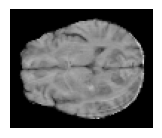

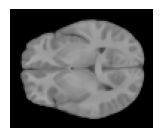

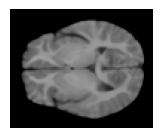

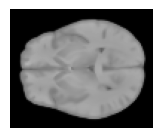

In [7]:
middle_slice_idx = int(image_array.size(-1) // 2)
i=0
plt.figure(figsize=(2, 2))
plt.imshow(image_array[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(prediction_m[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()


plt.figure(figsize=(2, 2))
plt.imshow(prediction[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(prediction_h[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

        

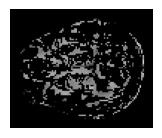

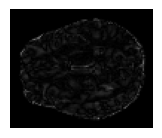

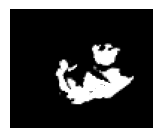

In [8]:
segmented = image_array * ((image_array < prediction) | (image_array > prediction_h)).float()
segmented = segmented*(image_array>0.001)
error = torch.abs(image_array-prediction_m)

middle_slice_idx = int(image_array.size(-1) // 2)

plt.figure(figsize=(2, 2))
plt.imshow(segmented[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(error[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()


plt.figure(figsize=(2, 2))
plt.imshow(sub_test['seg']['data'][i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()




        

In [ ]:
mask = torch.randn_like(image_array).to(device)
mask[mask<=0.5] = 0
mask[mask>0.5] = 1

In [ ]:
i =0
plt.figure(figsize=(2, 2))
plt.imshow(mask[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

In [ ]:
plt.figure(figsize=(2, 2))
masked_image = image_array*mask
plt.imshow(masked_image[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

In [ ]:
val_image_masked = image_array.to(device)*(1-mask)

In [ ]:
noise = torch.randn_like(image_array).to(device)
timesteps = torch.randint(50, 51, (image_array.shape[0],), device=image_array.device).long()
noise = noise*mask
_,model_out,_ = model(x=image_array*mask, timesteps=timesteps)
prediction,prediction_m,prediction_h = inferer(inputs=val_image_masked, diffusion_model=model, noise=noise, timesteps=timesteps)

In [ ]:
middle_slice_idx = int(image_array.size(-1) // 2)
i=0
plt.figure(figsize=(2, 2))
plt.imshow(image_array[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(prediction_m[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()


plt.figure(figsize=(2, 2))
plt.imshow(model_out[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(prediction_h[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

        

In [ ]:
segmented = image_array * ((image_array < prediction) | (image_array > prediction_h)).float()
segmented = segmented*(image_array>0.001)
error = torch.abs(image_array-prediction_m)

middle_slice_idx = int(image_array.size(-1) // 2)

plt.figure(figsize=(2, 2))
plt.imshow(segmented[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(error[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()


plt.figure(figsize=(2, 2))
plt.imshow(sub_test['seg']['data'][i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()




        

In [ ]:
import tqdm as tqdm
mask = mask.to(device)
val_image_masked = image_array.to(device)*mask
val_image_inpainted = torch.randn_like(image_array).to(device)

scheduler.set_timesteps(num_inference_steps=500)
progress_bar = tqdm.tqdm(scheduler.timesteps)

num_resample_steps = 10
with torch.no_grad():
    with autocast(enabled=True):
        for t in progress_bar:
            for u in range(num_resample_steps):
                # get the known portion at t-1
                if t > 0:
                    noise =  torch.randn_like(image_array).to(device)
                    timesteps_prev = torch.Tensor((t - 1,)).to(device).long()
                    val_image_inpainted_prev_known = scheduler.add_noise(
                        original_samples=val_image_masked, noise=noise, timesteps=timesteps_prev
                    )
                else:
                    val_image_inpainted_prev_known = val_image_masked

                # perform a denoising step to get the unknown portion at t-1
                if t > 0:
                    timesteps = torch.Tensor((t,)).to(device).long()
                    model_output = model(val_image_inpainted, timesteps=timesteps)
                    val_image_inpainted_prev_unknown, _ = scheduler.step(model_output, t, val_image_inpainted)

                # combine known and unknown using the mask
                val_image_inpainted = torch.where(
                    mask == 1, val_image_inpainted_prev_known, val_image_inpainted_prev_unknown
                )

                # perform resampling
                if t > 0 and u < (num_resample_steps - 1):
                    # sample x_t from x_t-1
                    noise = torch.randn_like(image_array).to(device)
                    val_image_inpainted = (
                        torch.sqrt(1 - scheduler.betas[t - 1]) * val_image_inpainted
                        + torch.sqrt(scheduler.betas[t - 1]) * noise
                    )


                    

# plot

